# 8. Shaded Triangles

이전 챕터에서 우리는 단색으로 채워진 삼각형을 그리는 알고리즘을 작성했다. 이번 단원에서는 그림자가 진 삼각형을 그리는 것이 목표이다.

## Defining Our Problem

![8_1](https://user-images.githubusercontent.com/74246766/142759901-cdc0eeab-ae2b-4227-add4-91ee7fab65d3.PNG)

우리가 원하는 그림은 위와 같은 그림이다. 이를 그리기 위해서 우리는 추가로 공식적인 정의를 알아야 한다.

<br></br>
$C : [0, 255, 0]$ 라는 값을 가지는 녹색이 있다고 하자. 우리는 이 색의 각 점에 실수 $h$를 적용할 것이다. 이 때 이 $h$는 지점에서의 색상의 강도가 된다.

<br></br>
$h$의 범위는 [0.0, 1.0]가 된다. 0.0이라면 그곳은 가능한 가장 어두운 곳인 검은색인 것이고 1.0이라면 그곳은 가능한 한 가장 밝은 색을 지녀 원색에 가장 가깝게 되는 것이다.(흰색이 되는 것이 아니다.)

그림자를 각 픽셀마다 계산하는 방법은 $C$에 $h$를 곱하는 것이다. 즉, $$C_h = (R_C * h, G_C * h, B_C * h)$$ 과 같다.

위 공식에 따라 $h=0.0$이면 검은색, $h=1.0$이면 원색 $h=0.5$이면 그 사이 정도로 어두워지는 것이다.

In [10]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

class Point:
    def __init__(self, x, y, h=1.0, color=[255,255,255]):
        self.x = x
        self.y = y
        self.h = h
        self.color = color

class Canvas:
    def __init__(self,
                 width=600, 
                 height=600):
        self.width = width
        self.height = height
        
        self.img = np.zeros((width,height,3), dtype = np.uint8) + 255
        
    def put_pixel(self, x, y, color,line_width):
        x = self.width/2 + x
        y = self.height/2 - y -1
        if (x< 0 or x >= self.width or y < 0 or y >= self.height):
            return 
        R = int(color[0])
        G = int(color[1])
        B = int(color[2])
        cv2.line(self.img, (int(x), int(y)), (int(x), int(y)), (R,G,B),line_width)
        
    def interpolate(self, i0, d0,i1, d1):
        if i0==i1:
            return [d0]
        else:
            values = []
            
            a = (d1-d0) / (i1 - i0)
            d = d0
            
            for i in range(i1 - i0+1):
                values.append(d)
                d += a
            return values
        
    def draw_line(self, p0, p1, color, line_width):
        if np.abs(p0.x - p1.x) > abs(p0.y - p1.y):
            # line is horizontal-ish
            if p0.x > p1.x:
                p0, p1 = p1, p0
            
            ys = self.interpolate(p0.x,p0.y,p1.x,p1.y)

            for i in range(p1.x-p0.x+1):
                self.put_pixel(i+p0.x,ys[i],color,line_width)
                    
        else:
            # line is vertical-ish
                        # line is horizontal-ish
            if p0.y > p1.y:
                p0, p1 = p1, p0
            
            xs = self.interpolate(p0.y,p0.x,p1.y,p1.x)
            for i in range(p1.y-p0.y+1):
                self.put_pixel(xs[i], i+p0.y, color, line_width)
                
    def draw_wireframe_triangle(self, p0, p1, p2, color, line_width):
        self.draw_line(p0, p1, color, line_width)
        self.draw_line(p1, p2, color, line_width)
        self.draw_line(p2, p0, color, line_width)
    
    def draw_filled_trangle(self, p0, p1, p2, color, line_width=1):
        if p1.y < p0.y:
            p0, p1 = p1, p0
        if p2.y < p0.y:
            p0, p2 = p2, p0
        if p2.y < p1.y:
            p2, p1 = p1, p2
            
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        
        x01.pop(-1)
        x012 = x01 + x12
        
        m = math.floor(len(x02) / 2)
        
        if x02[m] < x012[m]:
            x_left = x02
            x_right = x012
        else:
            x_left = x012
            x_right = x02
        
        for y in range(p0.y, p2.y + 1):
            for x in range(math.floor(x_left[y - p0.y]), math.floor(x_right[y - p0.y])+1):
                self.put_pixel(x, y, color, line_width)
                
    def draw_shaded_triangle(self, p0, p1, p2, color, line_width=1):
        if p1.y < p0.y:
            p0, p1 = p1, p0
        if p2.y < p0.y:
            p0, p2 = p2, p0
        if p2.y < p1.y:
            p2, p1 = p1, p2
            
        x01 = self.interpolate(p0.y, p0.x, p1.y, p1.x)
        h01 = self.interpolate(p0.y, p0.h, p1.y, p1.h)
        
        x12 = self.interpolate(p1.y, p1.x, p2.y, p2.x)
        h12 = self.interpolate(p1.y, p1.h, p2.y, p2.h)
        
        x02 = self.interpolate(p0.y, p0.x, p2.y, p2.x)
        h02 = self.interpolate(p0.y, p0.h, p2.y, p2.h)
        
        x01.pop(-1)
        x012 = x01 + x12
        
        h01.pop(-1)
        h012 = h01 + h12
        
        m = math.floor(len(x02) / 2)
        
        if x02[m] < x012[m]:
            x_left = x02
            h_left = h02
            
            x_right = x012
            h_right = h012
        else:
            x_left = x012
            h_left = h012
            
            x_right = x02
            h_right = h02
        
        for y in range(p0.y, p2.y + 1):
            xl = math.floor(x_left[y - p0.y])
            xr = math.floor(x_right[y - p0.y])
            h_segment = self.interpolate(xl, h_left[y - p0.y], xr, h_right[y - p0.y])
            for x in range(xl, xr + 1):
                self.put_pixel(x, y, np.dot(h_segment[x - xl], color), line_width)

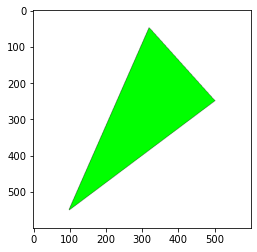

In [11]:
canvas1 = Canvas(600,600)
point5 = Point(-200, -250)
point6 = Point(200, 50)
point7 = Point(20, 250)

canvas1.draw_wireframe_triangle(point5, point6, point7, [0,0,0], 2)
canvas1.draw_filled_trangle(point5, point6, point7, [0,255,0], 1)

plt.imshow(canvas1.img)

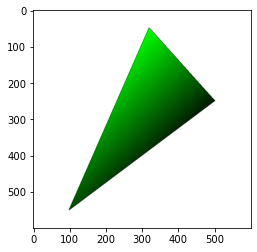

In [12]:
canvas2 = Canvas(600,600)
point5 = Point(-200, -250, 0.3)
point6 = Point(200, 50, 0.1)
point7 = Point(20, 250, 1.0)

canvas2.draw_wireframe_triangle(point5, point6, point7, [0,0,0], 2)
canvas2.draw_shaded_triangle(point5, point6, point7, [0,255,0], 1)

plt.imshow(canvas2.img)